In [1]:
# 通过ARMA模型分析全国的铁路客运量
# 数据来源：http://data.stats.gov.cn/easyquery.htm?cn=A01
# 通过Python进行了预处理，选取当期产量作为指标
library(forecast)
library(tseries)

In [3]:
library(readr)
train.data <- read_csv("clean_train_data.csv")

train.ts <- ts(train.data$Num, start = c(2005,1), end=c(2017, 9),
              frequency = 12)

# 选取部分的数据用于模型拟合
train <- window(train.ts, start=c(2005, 1), end=c(2017, 3))
head(train, 12)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Num = col_double()
)


        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2005 483.96 623.19 528.91 476.69 487.96 437.93 553.32 575.57 478.67 508.20
        Nov    Dec
2005 439.97 410.44

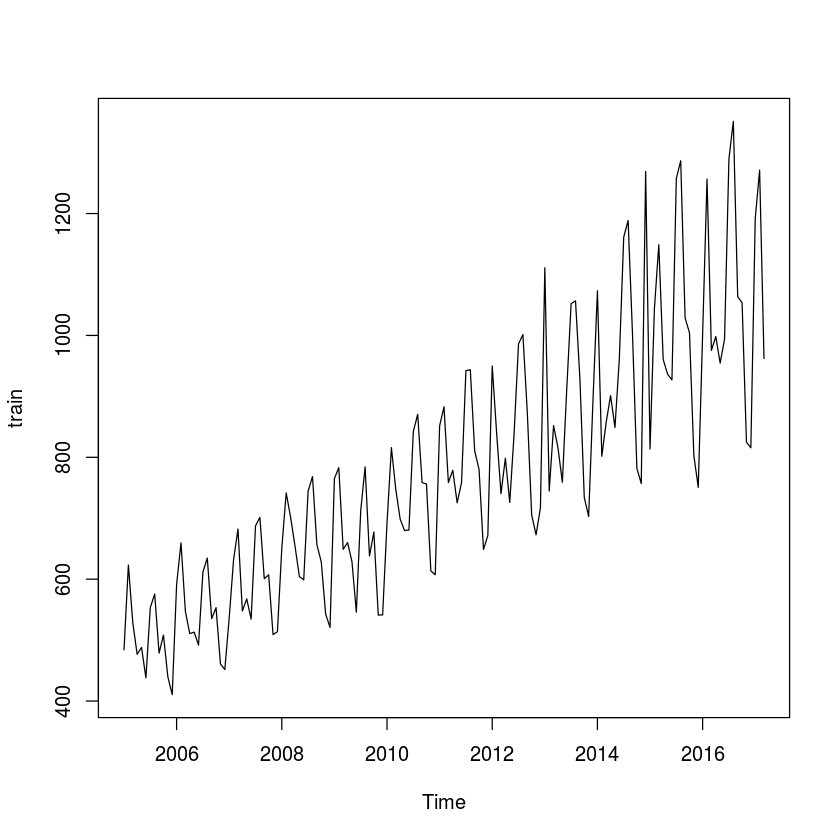

In [4]:
# 通过时序图初步观察
plot(train)

In [5]:
# 通过上图，很显然其不是平稳的。同时，我们使用ADF进行检验，也可得到其不是平稳的。
# ADF检验
library(aTSA)
stationary.test(train, method = "adf")


Attaching package: ‘aTSA’

The following objects are masked from ‘package:tseries’:

    adf.test, kpss.test, pp.test

The following object is masked from ‘package:forecast’:

    forecast

The following object is masked from ‘package:graphics’:

    identify



Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag     ADF p.value
[1,]   0 -0.8479   0.375
[2,]   1 -0.6896   0.432
[3,]   2 -0.1679   0.595
[4,]   3  0.0878   0.668
[5,]   4  0.7160   0.848
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -4.44  0.0100
[2,]   1 -3.96  0.0100
[3,]   2 -2.81  0.0638
[4,]   3 -2.28  0.2195
[5,]   4 -1.37  0.5675
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0  -9.33    0.01
[2,]   1 -11.10    0.01
[3,]   2  -9.95    0.01
[4,]   3 -10.43    0.01
[5,]   4  -6.64    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -13.6    0.01
[2,]   1 -12.8    0.01
[3,]   2 -11.0    0.01
[4,]   3 -14.3    0.01
[5,]   4 -13.6    0.01
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -13.6    0.01
[2,]   1 -12.8    0.01
[3,]   2 -11.0    0.01
[4,]   3 -14.3    0.01
[5,]   4 -13.8    0.01
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -13.5    0.01
[2,]   1 -12.8    0.01
[3,]   2 -11.0    0.01
[4,]   3 -14.3    0.01
[5,]   4 -13.7    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


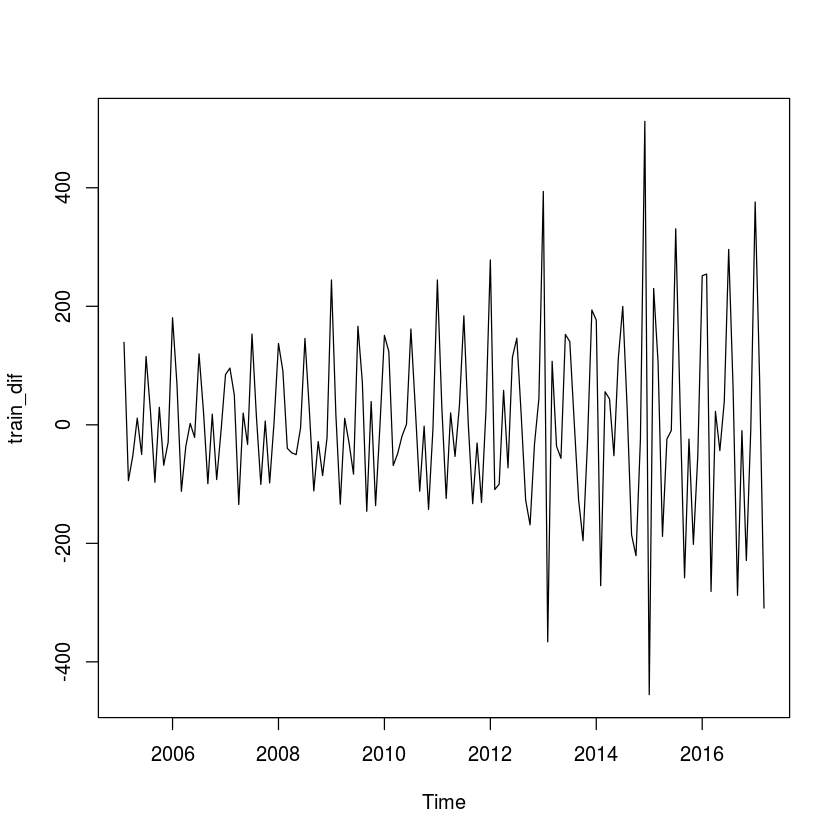

In [6]:
# 所以，我们进行差分，并对差分后的序列再次检验
library(forecast)
diff_n = ndiffs(train)  # 简单识别需要差分的阶数
train_dif = diff(train)
plot(train_dif)  
stationary.test(train_dif, method = "adf")

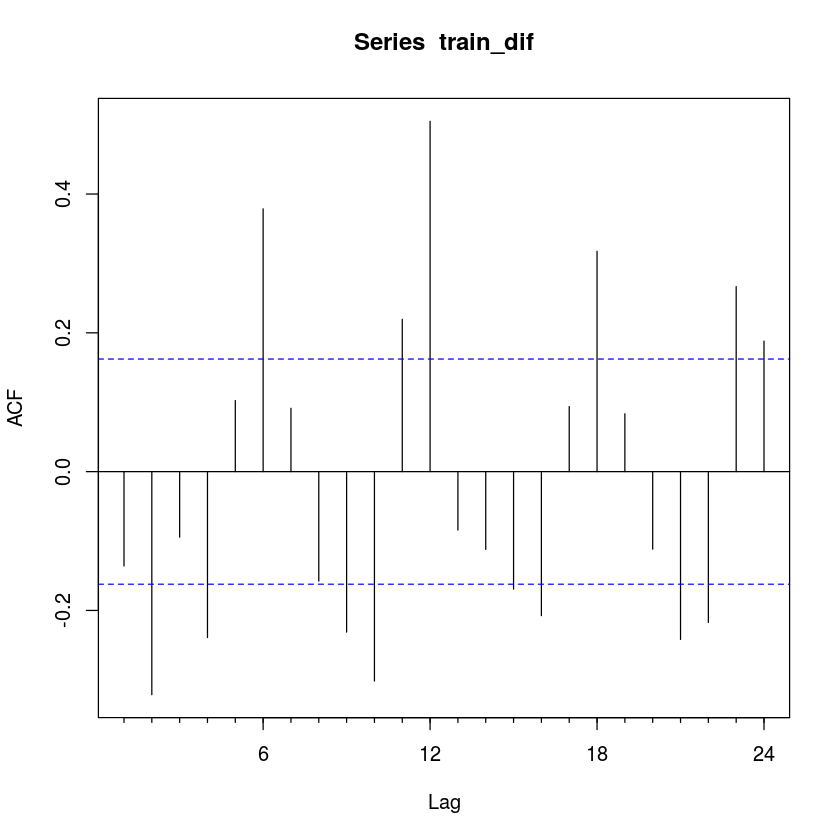

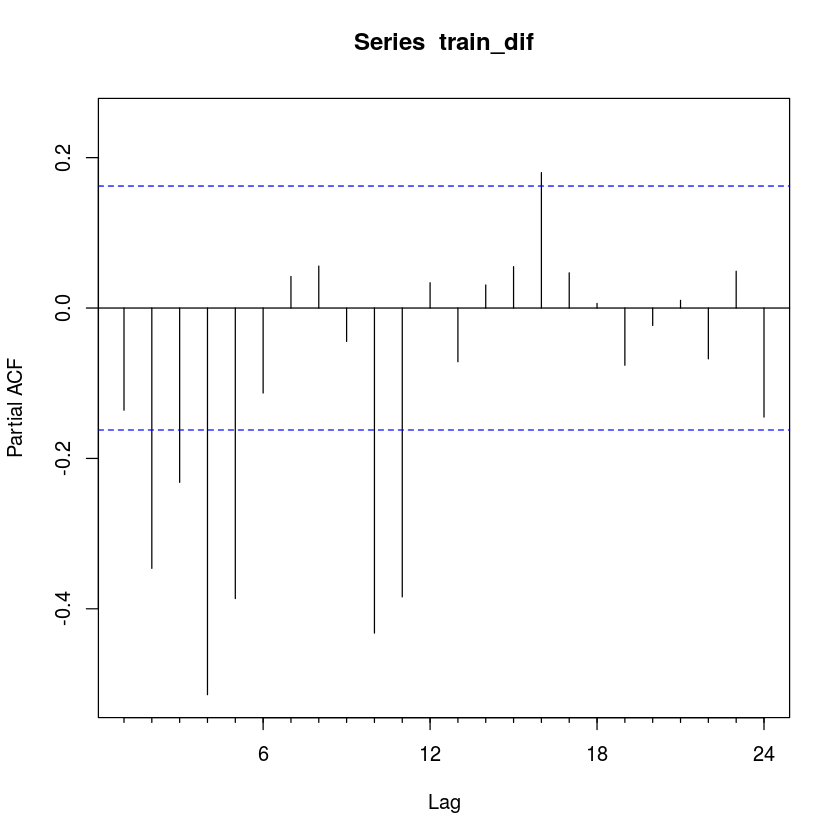

In [7]:
# 可以看到，此时已经平稳。亦即满足了ARMA建模的条件
# 下面，我们使用Box-Jenkins的方法进行建模
#　模型识别，ａｃｆ与ｐａｃｆ

Acf(train_dif)
Pacf(train_dif)

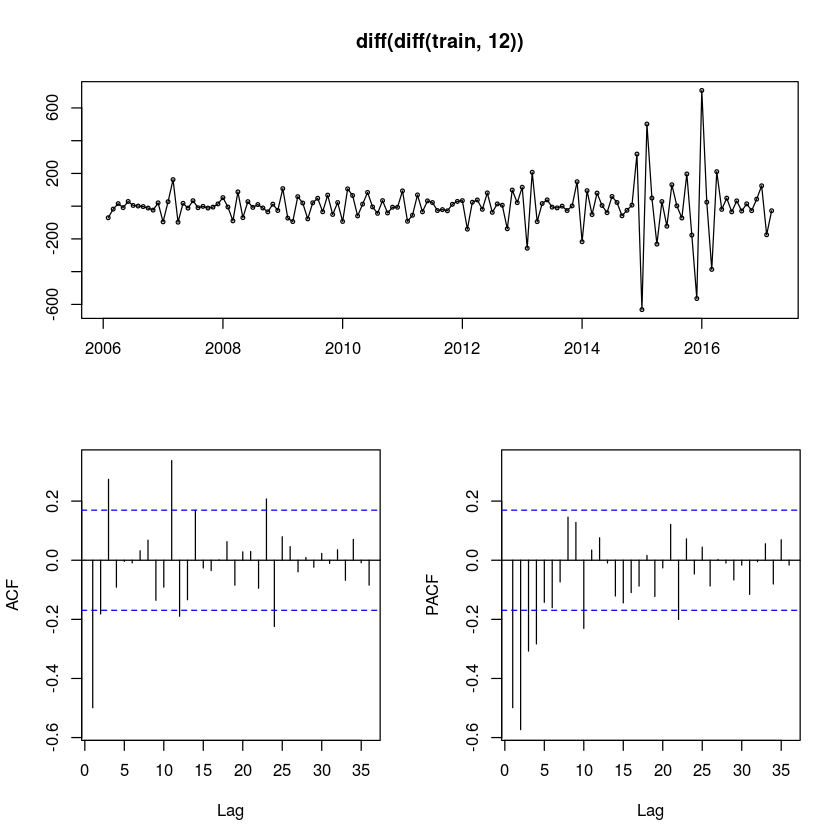

In [56]:
tsdisplay(diff(diff(train, 12)))


Call:
arima(x = train, order = c(4, 1, 3), seasonal = c(2, 1, 2))

Coefficients:
          ar1     ar2     ar3     ar4      ma1      ma2     ma3    sar1
      -0.4534  0.4311  0.2645  0.2895  -0.6677  -0.9979  0.6691  1.2431
s.e.   0.1648  0.1795  0.1041  0.0888   0.1712   0.0551  0.1578  0.1708
         sar2     sma1    sma2
      -0.6688  -1.6904  0.9802
s.e.   0.1280   0.7348  0.8130

sigma^2 estimated as 4780:  log likelihood = -772.35,  aic = 1568.71

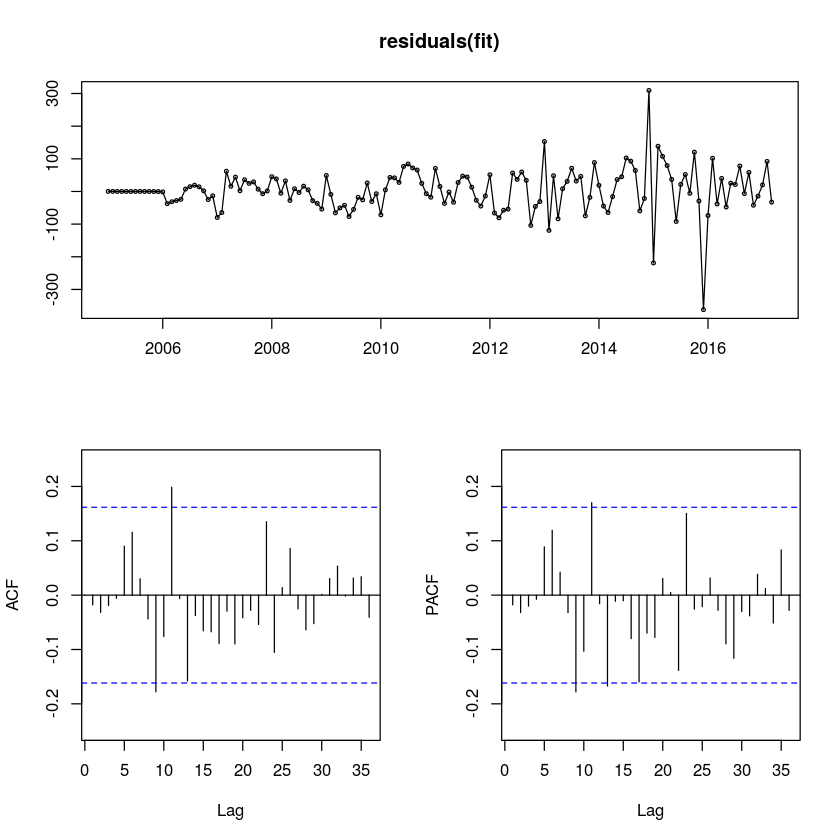

In [57]:
fit <- arima(train, order = c(4, 1 , 3),seasonal = c(2, 1 , 2))
fit
tsdisplay(residuals(fit))

Series: train 
ARIMA(1,0,3)(2,1,0)[12] with drift 

Coefficients:
         ar1      ma1      ma2     ma3     sar1    sar2   drift
      0.5231  -0.7442  -0.1155  0.3867  -0.2592  -0.325  4.2364
s.e.  0.1664   0.1608   0.1157  0.0863   0.0852   0.098  0.3887

sigma^2 estimated as 5842:  log likelihood=-775.28
AIC=1566.56   AICc=1567.7   BIC=1589.8

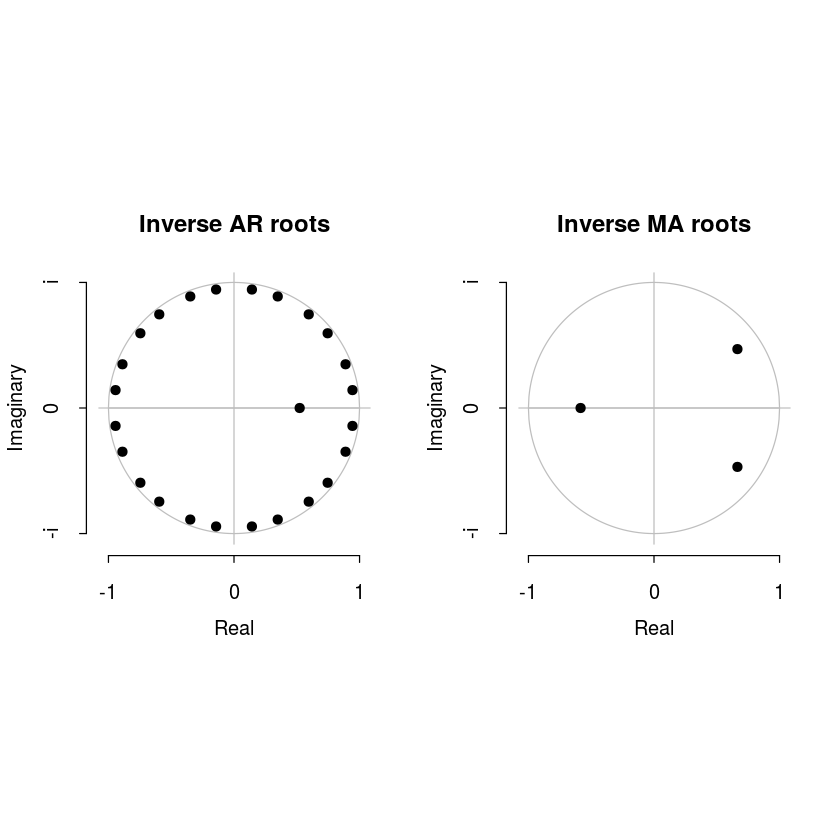

In [8]:
# 发现都是拖尾的。所以应该为ARMA模型
# 这块手动识别的理论还没有理解，直接用auto吧先...
# arima
#fit <- auto.arima(train)
#plot(fit)
#fit

# 可以看到已经通过了白噪声检验，意味着拟合效果比较好
# 下面，我们作出拟合的效果图
# plot(fit$fitted, col='green', lwd=1)
# lines(train, col='black', lwd=1.5)
# legend(2000, 24000, 
#        c("Fitted", "True Value"),
#        lty=c(1,1),
#        col=c("green", "black"))

In [63]:
# 模型已经建立，下面进行模型的检验
# 残差白噪声检验(Box-Pierce test)
Box.test(fit$residuals, lag=36)


	Box-Pierce test

data:  fit$residuals
X-squared = 31.214, df = 36, p-value = 0.6956


In [64]:
# 当然，也可以使用Box-Ljung test
Box.test(fit$residuals, lag=36, type = "Ljung-Box")


	Box-Ljung test

data:  fit$residuals
X-squared = 35.331, df = 36, p-value = 0.5002


In [66]:
# 可以看到，拟合效果已经是非常地好了。
# 我们还可以查看更多关于精度的信息
accuracy(fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,3.65017,66.0098,44.49851,-0.268939,5.456378,0.4206853,-0.01778903


         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Apr 2017       1030.458  937.3724 1123.544  888.0958 1172.821
May 2017       1033.070  939.2653 1126.875  889.6080 1176.532
Jun 2017       1055.456  960.2642 1150.649  909.8725 1201.040
Jul 2017       1334.541 1235.4985 1433.584 1183.0683 1486.014
Aug 2017       1361.859 1262.6956 1461.022 1210.2018 1513.516
Sep 2017       1142.605 1043.4153 1241.795  990.9072 1294.304


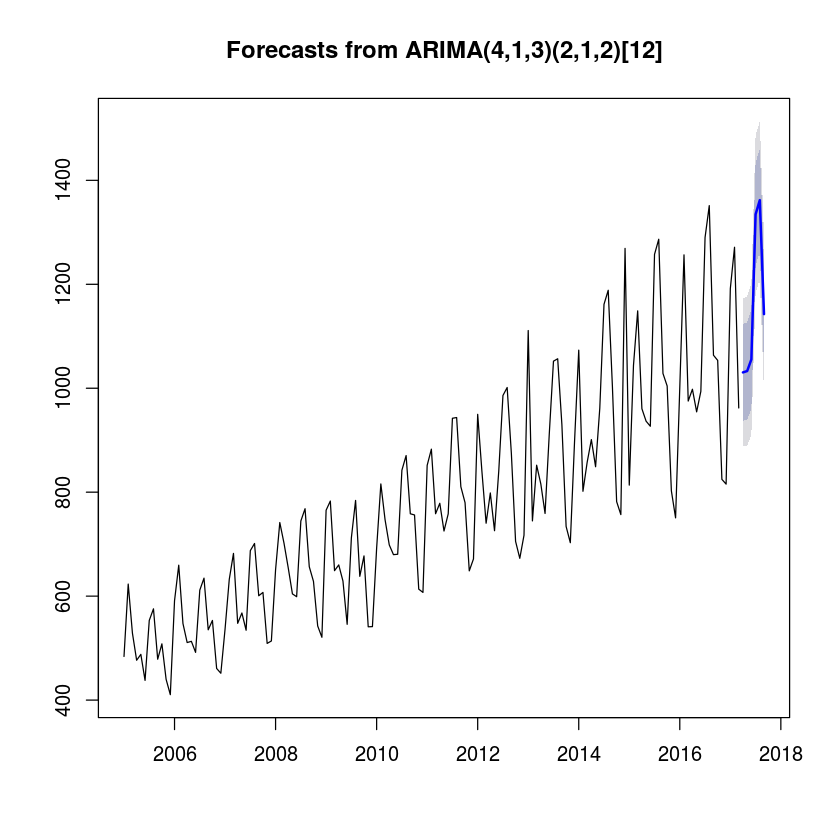

In [67]:
# 最后，我们对后面六个月的数据进行预测
# forecats
fore <- forecast::forecast(fit, h=6)
plot(fore)
print(fore)

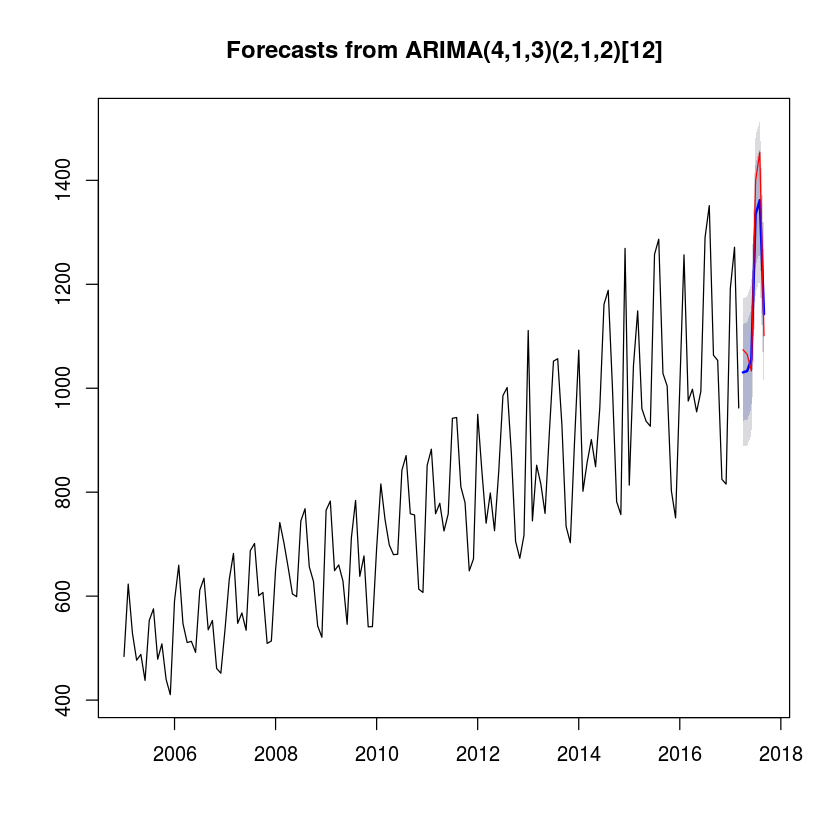

In [68]:
# 看起来一切都好的样子...
# 由于我们是有后面的真实数据的，所以我们放进去来作下对比
fore_true <- window(train.ts, start=c(2017, 4), end=c(2017, 9))
plot(fore)
lines(fore_true, col="red")

In [69]:
# 发现差别还是比较大的...
# 我们来具体看下残差
# plot(fore$residuals)
fore_true
fore$mean

         Apr     May     Jun     Jul     Aug     Sep
2017 1074.04 1065.21 1033.15 1398.55 1454.20 1100.96

          Apr      May      Jun      Jul      Aug      Sep
2017 1030.458 1033.070 1055.456 1334.541 1361.859 1142.605

In [70]:
RMSE = sqrt(mean((fore_true-fore$mean)^2))

In [71]:
RMSE

[1] 54.44913